# Pneumonia Identification Project

# Business and Data Understanding


According to the World Health Organization <https://www.who.int/health-topics/pneumonia/#tab=tab_1>, pneumonia is an acute respiratory infection that inflames the air sacs (alveoli) in one or both lungs. It can be caused by bacteria, viruses, or fungi making breathing difficult and reducing oxygen intake. It affects people of all ages but is especially dangerous for young children, older adults, and people with weakened immune systems. Despite the advances in science and medicine, pneumonia remains a major cause of mortality worldwide. In 2021, Pneumonia caused 2.18 million deaths globally, mainly in children younger than 5 years and adults over 70 years, and in those who are susceptible The lancet < https://www.thelancet.com/journals/lanres/article/PIIS2213-2600(25)00087-6/fulltext?utm_source>. With the development and use of an image classification neural network learning algorithm, it may be possible to detect pneumonia in young children and elderly adults in its early stages possibly leading to prompt treatment.

The data used for this project was retrieved from Kaggle datasets Chest X-Ray Images < https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia> this dataset is comprised of 5863 x-ray images divided between two classes, “Normal”, and “Pneumonia”. The chest X-ray images in the dataset were selected from pediatric patients of one to five years old from Guangzhou Women and Children’s Medical Center.


# Data preparation

For data preparation, I first used ImageDataGenerator tool to import all data. I used this tool because it would allow me to add random data augmentation parameters such as flips, rotations, etc. to the training data essentially creating synthetic data implementing a way to lower model bias. In the total data, there are 4506 images of pneumonia positive images while there are only 1350 images of pneumonia negative meaning that the data is heavily weighted towards pneumonia positive and as such can lead to severe model bias.

After I've imported all of my data, I reshaped the data essentially un-rowing the data to fit the model structural requirements of multiplying the image dimensions and image RGB layers (64 * 64 * 3). To complete my data preparations, I normalize the data bringing the data to a 0 to 1 scale to ensure all features are on a similar scale.

In [ ]:
# For Google Colab only
# Cell output cleared as it only contains installation progress information
!pip install keras
!pip install keras_preprocessing
!pip install tensorflow
!pip install scikeras[tensorflow]

In [1]:
# Importing tools and modules
from tensorflow import keras
from keras_preprocessing.image import ImageDataGenerator
from keras_preprocessing.image import array_to_img, img_to_array, load_img
import numpy as np

In [2]:
# Linking directory path
train_data_dir = 'data/chest_xray/train'
test_data_dir = 'data/chest_xray/test'
val_data_dir = 'data/chest_xray/val'

In [3]:
# Variable to add random data augmentations when importing
datagen = ImageDataGenerator(horizontal_flip=True,
                             vertical_flip=True,
                             rotation_range=25,
                             fill_mode='nearest')

In [4]:
# Getting train, test, and validation data from directory
train_generator = datagen.flow_from_directory(train_data_dir, target_size=(64, 64), batch_size=5000)
test_generator = ImageDataGenerator().flow_from_directory(test_data_dir, target_size=(64, 64), batch_size=624)
val_generator = ImageDataGenerator().flow_from_directory(val_data_dir, target_size=(64, 64), batch_size=232)

Found 5000 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 232 images belonging to 2 classes.


In [5]:
# Creating datasets (may take about 10 min as large dataset)
train_images, train_labels = next(train_generator)
test_images, test_labels = next(test_generator)
val_images, val_labels = next(val_generator)

In [6]:
print(np.shape(train_images))
print(np.shape(train_labels))
print(np.shape(test_images))
print(np.shape(test_labels))
print(np.shape(val_images))
print(np.shape(val_labels))

(5000, 64, 64, 3)
(5000, 2)
(624, 64, 64, 3)
(624, 2)
(232, 64, 64, 3)
(232, 2)


In [7]:
# Reshaping data
train_img_unrow = train_images.reshape(5000,-1)
test_img_unrow = test_images.reshape(624,-1)
val_img_unrow = val_images.reshape(232,-1)

In [8]:
# Checking data shape
print(np.shape(train_img_unrow))
print(np.shape(test_img_unrow))
print(np.shape(val_img_unrow))

(5000, 12288)
(624, 12288)
(232, 12288)


In [9]:
# Normalizing data
train_img_final = train_img_unrow/255.0
test_img_final = test_img_unrow/255.0
val_img_final = val_img_unrow/255.0

# Modeling

For the image classification neural network, model I imported tools and libraries from Tensorflow primarily Keras tools. To build the models I used Sequential due to its simplicity input to output linear stack model structure. To help with model tuning, I used an early stop method to track the model’s validation loss and stop the model if the validation loss no longer decreased or if it increased consecutively. I also implemented learning rate adjustments in the later models by reducing the learning rate of the model whenever validation accuracy results would plateau or decrease consecutively.

Due to the data’s heavy class imbalance, the model would often overfit, so to lower overfitting as best as possible I implemented dropout layers to randomly drop nodes in the model. Another method I took to lower overfitting was adding L2 kernel regularizers so to penalize the excessive pneumonia weight from the class imbalance.

In [10]:
# Importing modeling tools and modules
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns

In [11]:
# Function to quickly plot model results
def plot_results(model_results):
    """
    This function will take in the results of a model and plot the loss and accuracy of the model.

    Args:
    model_results (list): the results of the model in [] brackets.
    """
    for results in model_results:
        train_loss = results.history['loss']
        train_acc = results.history['accuracy']
        val_loss = results.history['val_loss']
        val_acc = results.history['val_accuracy']

        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
        sns.lineplot(x=results.epoch, y=train_loss, ax=ax1, label='train_loss')
        sns.lineplot(x=results.epoch, y=train_acc, ax=ax2, label='train_accuracy')

        sns.lineplot(x=results.epoch, y=val_loss, ax=ax1, label='val_loss')
        sns.lineplot(x=results.epoch, y=val_acc, ax=ax2, label='val_accuracy')
        ax1.set_title('Loss')
        ax2.set_title('Accuracy')
        ax1.legend();

In [12]:
# Function to quickly print out model evaluation for mulitple data sets
def model_evaluation(model, data_dict):
    """
    This function takes in a sequential model as a well as a dictionary of data and
    prints out the model evaluation results.

    Arguments:
    model: A trained model with .evaluate() capabilities
    data_dict: A dictionary where Keys are dataset names and Values are tuples (X, y) for data and labels.
    """
    for name, (X, y) in data_dict.items():
        loss, acc = model.evaluate(X, y)

        print(f'{name}, Loss: {loss:.4f}, Accuracy: {acc:.4f}')

In [13]:
# Creating dictionary for train, test, validation data
data_dict = {
    'Train Data': (train_images, train_labels),
    'Test Data': (test_images, test_labels),
    'Val Data': (val_images, val_labels)
}

In [14]:
# Creating dictionary for normalized train, test, validation data
data_dict_norm = {
    'Train Data': (train_img_final, train_labels),
    'Test Data': (test_img_final, test_labels),
    'Val Data': (val_img_final, val_labels)
}

### Model 1

In [15]:
model_1 = Sequential()

In [16]:
model_1.add(layers.Input(shape=(12288,)))
model_1.add(Dense(50, activation='relu'))
model_1.add(Dense(25, activation='relu'))
model_1.add(Dense(10, activation='relu'))
model_1.add(Dense(2, activation='softmax'))

In [17]:
model_1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [18]:
model_1_results = model_1.fit(train_img_final, train_labels,
                              epochs=10,
                              batch_size=125,
                              validation_data=(val_img_final, val_labels))

Epoch 1/10
40/40 [==============================] - 0s 6ms/step - loss: 0.9987 - accuracy: 0.6802 - val_loss: 0.5587 - val_accuracy: 0.6940
Epoch 2/10
40/40 [==============================] - 0s 3ms/step - loss: 0.3834 - accuracy: 0.8340 - val_loss: 0.6534 - val_accuracy: 0.6034
Epoch 3/10
40/40 [==============================] - 0s 4ms/step - loss: 0.3365 - accuracy: 0.8536 - val_loss: 0.4341 - val_accuracy: 0.8017
Epoch 4/10
40/40 [==============================] - 0s 3ms/step - loss: 0.3060 - accuracy: 0.8702 - val_loss: 0.4790 - val_accuracy: 0.7414
Epoch 5/10
40/40 [==============================] - 0s 4ms/step - loss: 0.3028 - accuracy: 0.8688 - val_loss: 0.5320 - val_accuracy: 0.7241
Epoch 6/10
40/40 [==============================] - 0s 3ms/step - loss: 0.2781 - accuracy: 0.8786 - val_loss: 0.4213 - val_accuracy: 0.7716
Epoch 7/10
40/40 [==============================] - 0s 3ms/step - loss: 0.2591 - accuracy: 0.8926 - val_loss: 0.7623 - val_accuracy: 0.6250
Epoch 8/10
40/40 [==

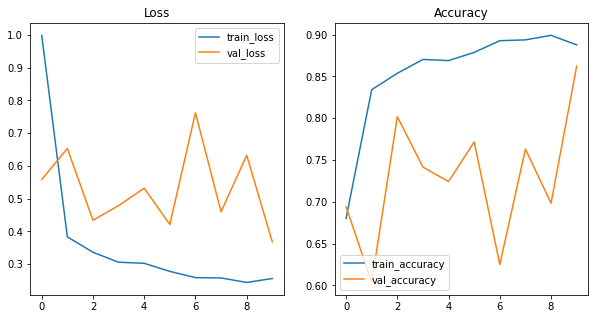

In [19]:
plot_results([model_1_results])

In [20]:
model_evaluation(model_1, data_dict_norm)

157/157 [==============================] - 0s 625us/step - loss: 0.2199 - accuracy: 0.9102
Train Data, Loss: 0.2199, Accuracy: 0.9102
20/20 [==============================] - 0s 600us/step - loss: 0.4488 - accuracy: 0.7853
Test Data, Loss: 0.4488, Accuracy: 0.7853
8/8 [==============================] - 0s 500us/step - loss: 0.3682 - accuracy: 0.8621
Val Data, Loss: 0.3682, Accuracy: 0.8621


### Model 2

In [21]:
model_2 = Sequential()

In [22]:
model_2.add(layers.Input(shape=(12288,)))
model_2.add(Dense(50, activation='relu'))
model_2.add(Dense(25, activation='relu'))
model_2.add(Dropout(0.5))
model_2.add(Dense(10, activation='relu'))
model_2.add(Dropout(0.2))
model_2.add(Dense(2, activation='softmax'))

In [23]:
model_2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [24]:
# Creating reduce learning rate callback variable
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.2, patience=2, min_lr=1e-5)

In [25]:
model_2_results = model_2.fit(train_img_final, train_labels,
                              epochs=50,
                              batch_size=300,
                              validation_data=(val_img_final, val_labels),
                              callbacks=[reduce_lr])

Epoch 1/50
17/17 [==============================] - 0s 9ms/step - loss: 1.2994 - accuracy: 0.6640 - val_loss: 0.7018 - val_accuracy: 0.5000
Epoch 2/50
17/17 [==============================] - 0s 6ms/step - loss: 0.6065 - accuracy: 0.7254 - val_loss: 0.6329 - val_accuracy: 0.5086
Epoch 3/50
17/17 [==============================] - 0s 6ms/step - loss: 0.5023 - accuracy: 0.7608 - val_loss: 0.6129 - val_accuracy: 0.5690
Epoch 4/50
17/17 [==============================] - 0s 6ms/step - loss: 0.4488 - accuracy: 0.7858 - val_loss: 0.6115 - val_accuracy: 0.5905
Epoch 5/50
17/17 [==============================] - 0s 6ms/step - loss: 0.4301 - accuracy: 0.8014 - val_loss: 0.5017 - val_accuracy: 0.7629
Epoch 6/50
17/17 [==============================] - 0s 6ms/step - loss: 0.4118 - accuracy: 0.8056 - val_loss: 0.5408 - val_accuracy: 0.7284
Epoch 7/50
17/17 [==============================] - 0s 6ms/step - loss: 0.3952 - accuracy: 0.8206 - val_loss: 0.5577 - val_accuracy: 0.6983
Epoch 8/50
17/17 [==

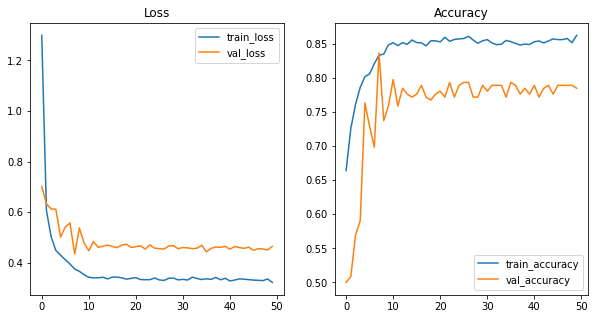

In [26]:
plot_results([model_2_results])

In [27]:
model_evaluation(model_2, data_dict_norm)

157/157 [==============================] - 0s 611us/step - loss: 0.2743 - accuracy: 0.8932
Train Data, Loss: 0.2743, Accuracy: 0.8932
20/20 [==============================] - 0s 600us/step - loss: 0.4120 - accuracy: 0.8157
Test Data, Loss: 0.4120, Accuracy: 0.8157
8/8 [==============================] - 0s 1ms/step - loss: 0.4651 - accuracy: 0.7845
Val Data, Loss: 0.4651, Accuracy: 0.7845


### Model 3

In [33]:
model_3 = Sequential()

In [34]:
model_3.add(layers.Input(shape=(12288,)))
model_3.add(Dense(50, activation='relu'))
model_3.add(Dense(50, activation='relu', kernel_regularizer=l2(0.5)))
model_3.add(Dropout(0.5))
model_3.add(Dense(25, activation='relu'))
model_3.add(Dense(25, activation='relu', kernel_regularizer=l2(l2=0.25)))
model_3.add(Dropout(0.2))
model_3.add(Dense(10, activation='relu'))
model_3.add(Dense(2, activation='softmax'))

In [35]:
model_3.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [36]:
# Creating early stop callback variable
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [37]:
model_3_results = model_3.fit(train_img_final, train_labels,
                              epochs=40,
                              batch_size=350,
                              validation_data=(val_img_final, val_labels),
                              callbacks=[reduce_lr, early_stop])

Epoch 1/40
15/15 [==============================] - 0s 12ms/step - loss: 29.7799 - accuracy: 0.6736 - val_loss: 27.0822 - val_accuracy: 0.5000
Epoch 2/40
15/15 [==============================] - 0s 6ms/step - loss: 24.9059 - accuracy: 0.7348 - val_loss: 22.6752 - val_accuracy: 0.5000
Epoch 3/40
15/15 [==============================] - 0s 7ms/step - loss: 20.7801 - accuracy: 0.7528 - val_loss: 18.9342 - val_accuracy: 0.5000
Epoch 4/40
15/15 [==============================] - 0s 7ms/step - loss: 18.4413 - accuracy: 0.7546 - val_loss: 18.2374 - val_accuracy: 0.5000
Epoch 5/40
15/15 [==============================] - 0s 8ms/step - loss: 17.7774 - accuracy: 0.7566 - val_loss: 17.5543 - val_accuracy: 0.5000
Epoch 6/40
15/15 [==============================] - 0s 7ms/step - loss: 17.3551 - accuracy: 0.7576 - val_loss: 17.4471 - val_accuracy: 0.5000
Epoch 7/40
15/15 [==============================] - 0s 7ms/step - loss: 17.2217 - accuracy: 0.7576 - val_loss: 17.3062 - val_accuracy: 0.5000
Epoch

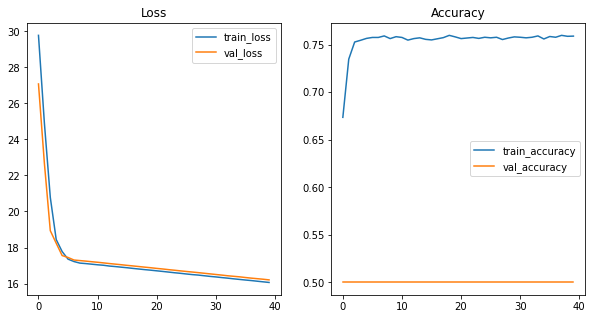

In [38]:
plot_results([model_3_results])

In [39]:
model_evaluation(model_3, data_dict_norm)

157/157 [==============================] - 0s 654us/step - loss: 16.0145 - accuracy: 0.7534
Train Data, Loss: 16.0145, Accuracy: 0.7534
20/20 [==============================] - 0s 600us/step - loss: 16.1141 - accuracy: 0.6250
Test Data, Loss: 16.1141, Accuracy: 0.6250
8/8 [==============================] - 0s 500us/step - loss: 16.2029 - accuracy: 0.5000
Val Data, Loss: 16.2029, Accuracy: 0.5000


### Model 4

In [40]:
model_4 = Sequential()

In [41]:
model_4.add(layers.Input(shape=(12288,)))
model_4.add(Dense(75, activation='relu'))
model_4.add(Dense(50, activation='relu'))
model_4.add(Dropout(0.5))
model_4.add(Dense(50, activation='relu', kernel_regularizer=l2(l2=0.5)))
model_4.add(Dense(25, activation='relu'))
model_4.add(Dropout(0.25))
model_4.add(Dense(25, activation='relu', kernel_regularizer=l2(l2=0.25)))
model_4.add(Dense(10, activation='relu', kernel_regularizer=l2(l2=0.01)))
model_4.add(Dense(2, activation='softmax'))

In [42]:
model_4.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [43]:
model_4_results = model_4.fit(train_img_final, train_labels,
                              epochs=50,
                              batch_size=250,
                              validation_data=(val_img_final, val_labels),
                              callbacks=[early_stop])

Epoch 1/50
20/20 [==============================] - 0s 9ms/step - loss: 28.6768 - accuracy: 0.6844 - val_loss: 25.3892 - val_accuracy: 0.5000
Epoch 2/50
20/20 [==============================] - 0s 6ms/step - loss: 22.6031 - accuracy: 0.7504 - val_loss: 20.0296 - val_accuracy: 0.5000
Epoch 3/50
20/20 [==============================] - 0s 6ms/step - loss: 17.7390 - accuracy: 0.7518 - val_loss: 15.7527 - val_accuracy: 0.5000
Epoch 4/50
20/20 [==============================] - 0s 6ms/step - loss: 13.8741 - accuracy: 0.7536 - val_loss: 12.3256 - val_accuracy: 0.5000
Epoch 5/50
20/20 [==============================] - 0s 6ms/step - loss: 10.8341 - accuracy: 0.7674 - val_loss: 9.6562 - val_accuracy: 0.5000
Epoch 6/50
20/20 [==============================] - 0s 6ms/step - loss: 8.4519 - accuracy: 0.7884 - val_loss: 7.5669 - val_accuracy: 0.6638
Epoch 7/50
20/20 [==============================] - 0s 6ms/step - loss: 6.5727 - accuracy: 0.8116 - val_loss: 5.8988 - val_accuracy: 0.7931
Epoch 8/50


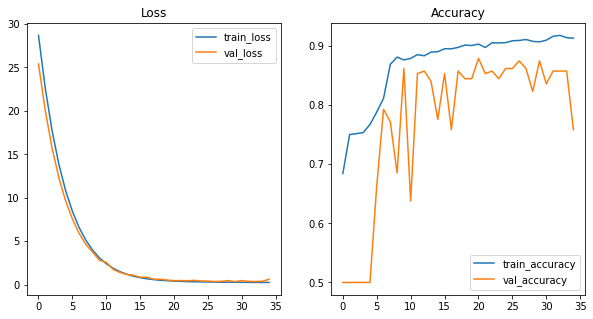

In [44]:
plot_results([model_4_results])

In [45]:
model_evaluation(model_4, data_dict_norm)

157/157 [==============================] - 0s 645us/step - loss: 0.2822 - accuracy: 0.9080
Train Data, Loss: 0.2822, Accuracy: 0.9080
20/20 [==============================] - 0s 400us/step - loss: 0.4941 - accuracy: 0.8045
Test Data, Loss: 0.4941, Accuracy: 0.8045
8/8 [==============================] - 0s 500us/step - loss: 0.3610 - accuracy: 0.8750
Val Data, Loss: 0.3610, Accuracy: 0.8750


### Model 5

In [70]:
model_5 = models.Sequential()

In [71]:
model_5.add(layers.Input(shape=(64, 64, 3)))
model_5.add(layers.Conv2D(16, (5, 5), activation='relu'))
model_5.add(layers.BatchNormalization())
model_5.add(layers.MaxPooling2D())

model_5.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same'))
model_5.add(layers.BatchNormalization())

model_5.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(l2=0.000001)))
model_5.add(layers.BatchNormalization())
model_5.add(layers.Dropout(0.5))
model_5.add(layers.MaxPooling2D())

model_5.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))

model_5.add(layers.Conv2D(64, (3, 3), activation='relu', padding='valid'))
model_5.add(layers.MaxPooling2D())

#model_5.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
#model_5.add(layers.Dropout(0.25))

model_5.add(layers.Conv2D(128, (3, 3), activation='relu', padding='valid', kernel_regularizer=l2(l2=0.00001)))
model_5.add(layers.Dropout(0.1))
model_5.add(layers.MaxPooling2D())

model_5.add(layers.Flatten())
model_5.add(layers.Dense(2, activation='softmax'))

In [72]:
model_5.compile(Adam(learning_rate=0.00003), loss='categorical_crossentropy', metrics=['accuracy'])

In [73]:
model_5_results = model_5.fit(train_images, train_labels,
                              epochs=10, batch_size=800,
                              validation_data=(val_images, val_labels),
                              callbacks=[early_stop, reduce_lr],
                              verbose=2)

Epoch 1/10
7/7 - 6s - loss: 1.3841 - accuracy: 0.2614 - val_loss: 1.7525 - val_accuracy: 0.5000
Epoch 2/10
7/7 - 6s - loss: 0.7625 - accuracy: 0.5676 - val_loss: 0.8192 - val_accuracy: 0.5000
Epoch 3/10
7/7 - 6s - loss: 0.6246 - accuracy: 0.7380 - val_loss: 0.7257 - val_accuracy: 0.4310
Epoch 4/10
7/7 - 6s - loss: 0.6357 - accuracy: 0.7490 - val_loss: 0.7233 - val_accuracy: 0.4267
Epoch 5/10
7/7 - 6s - loss: 0.6155 - accuracy: 0.7500 - val_loss: 0.7213 - val_accuracy: 0.4440
Epoch 6/10
7/7 - 6s - loss: 0.5961 - accuracy: 0.7496 - val_loss: 0.7208 - val_accuracy: 0.4828
Epoch 7/10
7/7 - 6s - loss: 0.5758 - accuracy: 0.7506 - val_loss: 0.7212 - val_accuracy: 0.5000
Epoch 8/10
7/7 - 6s - loss: 0.5623 - accuracy: 0.7500 - val_loss: 0.7210 - val_accuracy: 0.5000
Epoch 9/10
7/7 - 6s - loss: 0.5583 - accuracy: 0.7466 - val_loss: 0.7189 - val_accuracy: 0.5000
Epoch 10/10
7/7 - 6s - loss: 0.5446 - accuracy: 0.7534 - val_loss: 0.7144 - val_accuracy: 0.5086


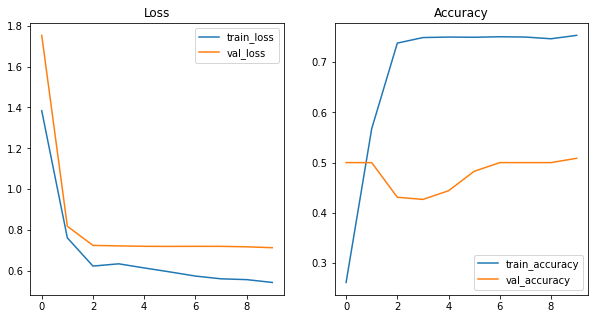

In [74]:
plot_results([model_5_results])

In [75]:
model_evaluation(model_5, data_dict)

157/157 [==============================] - 1s 9ms/step - loss: 0.7667 - accuracy: 0.3090
Train Data, Loss: 0.7667, Accuracy: 0.3090
20/20 [==============================] - 0s 9ms/step - loss: 0.7474 - accuracy: 0.4054
Test Data, Loss: 0.7474, Accuracy: 0.4054
8/8 [==============================] - 0s 8ms/step - loss: 0.7144 - accuracy: 0.5086
Val Data, Loss: 0.7144, Accuracy: 0.5086


# Evaluation

The model that performed the best overall and will be the final model is model 5, the Convolutional Neural Network. Although this model has a rough start, it quickly course corrects and starts to learn from the data leading the model to generalize better resulting in quickly lowering train and validation loss, and increasing accuracy and validation accuracy.

### Final Model

In [ ]:
final_model = Sequential()

In [ ]:
final_model.add(layers.Input(shape=(64, 64, 3)))
final_model.add(layers.Conv2D(16, (5, 5), activation='relu'))
final_model.add(layers.BatchNormalization())
final_model.add(layers.MaxPooling2D())

final_model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same'))
final_model.add(layers.BatchNormalization())

final_model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(l2=0.00001)))
final_model.add(layers.BatchNormalization())
final_model.add(layers.Dropout(0.5))
final_model.add(layers.MaxPooling2D())

final_model.add(layers.Conv2D(64, (5, 5), activation='relu', padding='same'))

final_model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='valid'))
final_model.add(layers.MaxPooling2D())

final_model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))

final_model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='valid', kernel_regularizer=l2(l2=0.00001)))
final_model.add(layers.Dropout(0.1))
final_model.add(layers.MaxPooling2D())

final_model.add(layers.Flatten())
final_model.add(layers.Dense(2, activation='softmax'))

In [ ]:
final_model.compile(Adam(learning_rate=0.00003), loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
final_model_results = final_model.fit(train_images, train_labels,
                                      epochs=100, batch_size=600,
                                      validation_data=(val_images, val_labels),
                                      callbacks=[early_stop, reduce_lr])

In [ ]:
plot_results([final_model_results])

In [ ]:
model_evaluation(final_model, data_dict)

In [ ]:
test_img_pred = final_model.predict(test_images)

# Plotting Confusion Matrix of final Model
fig, ax = plt.subplots(figsize=(10, 8))

ax.set_title('Final Model Results')

test_img_pred_labels = np.argmax(test_img_pred, axis=1)
test_true_labels = np.argmax(test_labels, axis=1)

cm = confusion_matrix(test_img_pred_labels, test_true_labels)

ConfusionMatrixDisplay(confusion_matrix=cm,
                       display_labels=['Neg-Pneumonia', 'Pos-Pneumonia']).plot(ax=ax, cmap='Blues', colorbar=False)

plt.tight_layout();

# Limitations

A limitation I encountered in this project is the data itself and how heavily weighted it is towards pneumonia positive. While there are methods that can help alleviate the class weight imbalance and maybe even lessen model bias through the creation of synthetic data, synthetic data generated from these methods isn't as reliable as real data.

# Next Steps

For some next steps, further model tweaks and parameter tuning may be necessary to improve the model overall performance. While an 86% is not terrible for accuracy with unseen test data, it does leave a little more to be desired especially with a loss of nearly .30 this tells us the model is missing the mark a little less than a third of the time.

Another potential next step if time permits would be using other Convolutional neural networks such as ResNet, DenseNet or ViT (Vision Transformers) image classification algorithms and comparing results to the current final model as the base model.

Lastly, the next step I believe can be greatly benificial to the overall project is gathering more data, especially gathering more x-ray images of healthy pnuemonia free lungs. As stated before the data's class weights are heavily weighted towards pnuemonia positive which can lead to model bias.